In [5]:
import torch
# 对图像数据的原始处理需要
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [6]:
# 准备数据
 
batch_size = 64
#我们拿到的图片是pillow,我们要把他转换成模型里能训练的tensor也就是张量的格式
# 0到255的值变为0到1符合正态分布的值,并且28x28的图像变为1x28x28的张量,这里的1是通道数
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) # 归一化,均值和方差,经验值
 
train_dataset = datasets.MNIST(root='../dataset/mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = datasets.MNIST(root='../dataset/mnist/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [7]:
# 设计模式
 
 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = torch.nn.Linear(784, 512)
        self.l2 = torch.nn.Linear(512, 256)
        self.l3 = torch.nn.Linear(256, 128)
        self.l4 = torch.nn.Linear(128, 64)
        self.l5 = torch.nn.Linear(64, 10)
 
    def forward(self, x):
        # (N,1,28,28) -> (N,784)        
        x = x.view(-1, 784)  # -1其实就是自动获取mini_batch
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)  # 最后一层不做激活，不进行非线性变换
 
 
model = Net()
 
# 构造损失和优化
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

[1,   300] loss: 2.215
[1,   600] loss: 0.974
[1,   900] loss: 0.442
accuracy on test set: 90 % 
[2,   300] loss: 0.329
[2,   600] loss: 0.265
[2,   900] loss: 0.231
accuracy on test set: 94 % 
[3,   300] loss: 0.188
[3,   600] loss: 0.172
[3,   900] loss: 0.161
accuracy on test set: 95 % 
[4,   300] loss: 0.131
[4,   600] loss: 0.129
[4,   900] loss: 0.122
accuracy on test set: 96 % 
[5,   300] loss: 0.102
[5,   600] loss: 0.094
[5,   900] loss: 0.099
accuracy on test set: 96 % 
[6,   300] loss: 0.077
[6,   600] loss: 0.077
[6,   900] loss: 0.080
accuracy on test set: 97 % 
[7,   300] loss: 0.062
[7,   600] loss: 0.063
[7,   900] loss: 0.063
accuracy on test set: 96 % 
[8,   300] loss: 0.050
[8,   600] loss: 0.052
[8,   900] loss: 0.054
accuracy on test set: 97 % 
[9,   300] loss: 0.041
[9,   600] loss: 0.042
[9,   900] loss: 0.042
accuracy on test set: 97 % 
[10,   300] loss: 0.030
[10,   600] loss: 0.034
[10,   900] loss: 0.037
accuracy on test set: 97 % 


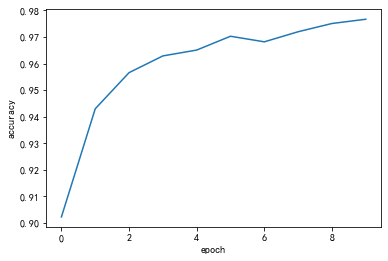

In [8]:
# 训练
 
 
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        # 获得一个批次的数据和标签
        # x,y        
        inputs, target = data
        optimizer.zero_grad()
        # 获得模型预测结果(64, 10)
        outputs = model(inputs)
        # 交叉熵代价函数outputs(64,10),target（64）
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        # 把损失加起来
        running_loss += loss.item()
        # 每300次迭代输出一下数据    
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0
 
#  测试
def test():
    correct = 0
    total = 0
    # test不需要计算梯度    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            # 我们取概率最大的那个数作为输出 
            _, predicted = torch.max(outputs.data, dim=1) # dim = 1 列是第0个维度，行是第1个维度
            total += labels.size(0)
            # 推测的分类与label分类做比较           
            correct += (predicted == labels).sum().item() # 张量之间的比较运算
    print('accuracy on test set: %d %% ' % (100*correct/total))
    return correct/total
 
 
if __name__ == '__main__':
    epoch_list = []
    acc_list = []
    
    for epoch in range(10):
        train(epoch)
        acc = test()
        epoch_list.append(epoch)
        acc_list.append(acc)
    
    plt.plot(epoch_list,acc_list)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()